# Customer Segmentation in the TIC dataset via K-means

#### Setting marketing strategies and campaigns would be more effective using the resulted demographic or behavioral segments instead of using the same marketing plan for all customers.

#### Reference:  https://www.sciencedirect.com/science/article/pii/S1877050918322385

#### Data source: https://kdd.ics.uci.edu/databases/tic/tic.data.html

#### Feature definition: https://kdd.ics.uci.edu/databases/tic/dictionary.txt

In [2]:
import time
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns
import math
from sklearn.cluster import KMeans
from sklearn import metrics
from operator import itemgetter
from math import log
import matplotlib.pyplot as plt
%matplotlib inline

## Load data set

#### load the csv file into a pandas dataframe.

In [3]:
df_tv = pd.read_csv('/v3io/bigdata/intelligence/tic2000/ticdata2000.txt', sep='\t', header=None, dtype=str, na_filter=False)

print(df_tv.shape)

df_pre = pd.read_csv('/v3io/bigdata/intelligence/tic2000/ticeval2000.txt', sep='\t', header=None, dtype=str, na_filter=False)

print(df_pre.shape)

df = pd.concat([df_tv.iloc[:,0:85], df_pre])

print(df.shape)

df.head()

(5822, 86)
(4000, 85)
(9822, 85)


0  1  2  3   4  5  6  7  8  9  ... 75 76 77 78 79 80 81 82 83 84
0  33  1  3  2   8  0  5  1  3  7 ...  0  0  0  0  1  0  0  0  0  0
1  37  1  2  2   8  1  4  1  4  6 ...  0  0  0  0  1  0  0  0  0  0
2  37  1  2  2   8  0  4  2  4  3 ...  0  0  0  0  1  0  0  0  0  0
3   9  1  3  3   3  2  3  2  4  5 ...  0  0  0  0  1  0  0  0  0  0
4  40  1  4  2  10  1  4  1  4  7 ...  0  0  0  0  1  0  0  0  0  0

[5 rows x 85 columns]

#### Once loaded, convert the txt data to a NumPy array.

In [4]:
a = np.array(df).astype(np.float)

print(a.shape)

(9822, 85)


## Data Visualization

### Draw histogram of pairwise distances

#### To reveal the tendency of the data to be clustered I plot the histogram of the pairwise distances of all records in the dataset. The resulted graph contains two peaks and this means that the dataset contains clusters. 

(48230931,)


/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(array([9.01278893e-05, 7.50062986e-05, 3.54976333e-05, 2.65931422e-05,
        9.17323021e-05, 5.03785621e-05, 1.44958697e-04, 1.40787224e-04,
        1.01920323e-04, 2.33401953e-04, 3.03354351e-04, 4.74705638e-04,
        8.25751160e-04, 1.14214136e-03, 1.86781728e-03, 2.59642124e-03,
        4.13758007e-03, 5.81266726e-03, 8.76566925e-03, 1.14622460e-02,
        1.59959154e-02, 2.18769307e-02, 2.63552078e-02, 3.04000127e-02,
        3.72252650e-02, 4.40687675e-02, 4.69134315e-02, 5.22859281e-02,
        5.30587336e-02, 5.63576871e-02, 5.51257789e-02, 5.65112294e-02,
        5.36875431e-02, 5.38931887e-02, 5.30606188e-02, 4.95450696e-02,
        4.57679209e-02, 4.42361077e-02, 4.22278642e-02, 3.81141899e-02,
        3.61500276e-02, 3.23059749e-02, 3.03759465e-02, 2.75781715e-02,
        2.64720091e-02, 2.48983609e-02, 2.47958389e-02, 2.40851642e-02,
        2.46422565e-02, 2.45681727e-02, 2.57270401e-02, 2.72163764e-02,
        2.76273066e-02, 2.92251012e-02, 2.93908371e-02, 2.949857

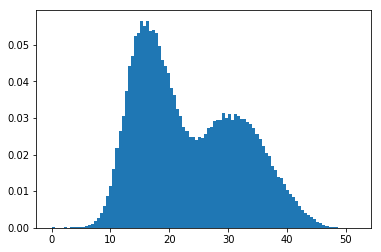

In [5]:
from scipy.spatial.distance import euclidean, pdist

p2 = pdist(a, euclidean)

print(p2.shape)

plt.hist(p2, normed=True, bins=100)

### Visualizing high-dimensional dataset using t-SNE

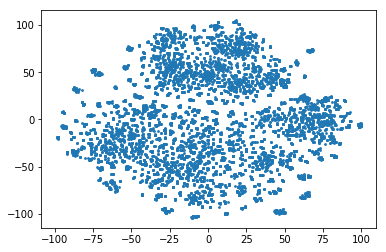

In [6]:
x = TSNE(random_state=20190509).fit_transform(a)

plt.scatter(x[:,0], x[:,1], lw=0, s=8)

#### tune t-SNE for better visualization

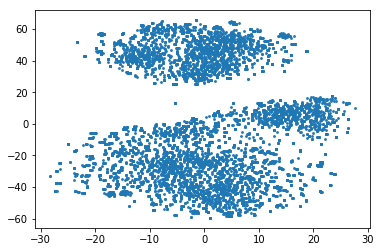

In [7]:
x_b = TSNE(random_state=20190509, perplexity=300, early_exaggeration=20).fit_transform(a)

plt.scatter(x_b[:,0], x_b[:,1], lw=0, s=8)

#### Coloring each record by customer main type (L2)

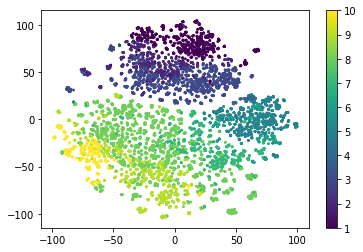

In [25]:
sc = plt.scatter(x[:,0], x[:,1], lw=0, s=8, c=list(a[:,4]))

plt.colorbar(sc)

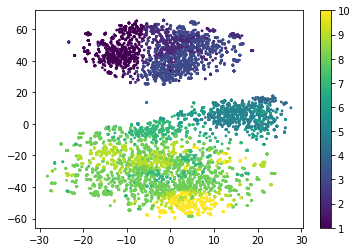

In [24]:
sc = plt.scatter(x_b[:,0], x_b[:,1], lw=0, s=8, c=list(a[:,4]))

plt.colorbar(sc)

#### Coloring each record by customer subtype (L0)

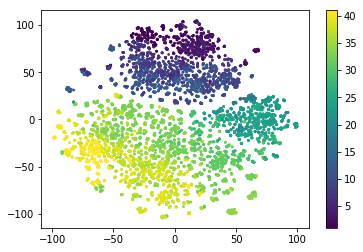

In [23]:
sc = plt.scatter(x[:,0], x[:,1], lw=0, s=8, c=list(a[:,0]))

plt.colorbar(sc)

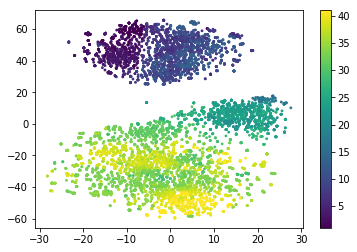

In [22]:
sc = plt.scatter(x_b[:,0], x_b[:,1], lw=0, s=8, c=list(a[:,0]))

plt.colorbar(sc)

## Experiment I (K-means)

### Choose Number of Clusters

#### Implement Elbow Method to find the optimal k, that is to repeatedly run k-means clustering on the dataset for a range of values of k, and for each value of k calculate the sum of squared errors (SSE). Then, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best.   

In [5]:
def elbow(data):
    SSE=[]
    k_vals=[2,3,4,5,6,7,8,9,10,11]
    for k in k_vals:
        model=KMeans(n_clusters=k,max_iter=500, n_init=10)
        model.fit(data)
        SSE.append(model.inertia_)
        
    X = range(2,12)
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.plot(X,SSE,'o-')
    plt.grid(True, linestyle = "-", linewidth = "1")
    plt.title("SSE of different k values")
    my_x_ticks = np.arange(2, 12, 1)
    plt.xticks(my_x_ticks)
    plt.show()

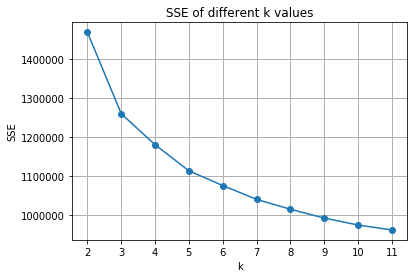

In [13]:
elbow(a)

### Silhouette Analysis

#### Sometimes it’s still hard to figure out a good number of clusters to use because the curve is monotonically decreasing and may not show any elbow or has an obvious point where the curve starts flattening out.

#### Silhouette analysis can be used to determine the degree of separation between clusters.  When Silhouette score is close to 1, we have a good clusters.

#### I useg average Silhouette scores with SSE to help determine cluster numbers.

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score

def silhouette_analysis(data):
    sa=[]
    k_vals=[2,3,4,5,6,7,8,9,10,11]
    for k in k_vals:
        model=KMeans(n_clusters=k,max_iter=500, n_init=10)
        model.fit(data)
        sa.append(silhouette_score(data, model.fit_predict(data)))
        
    X = range(2,12)
    plt.xlabel('k')
    plt.ylabel('average silhouette score')
    plt.plot(X,sa,'o-')
    plt.grid(True, linestyle = "-", linewidth = "1")
    plt.title("Silhouette analysis of different k values")
    my_x_ticks = np.arange(2, 12, 1)
    plt.xticks(my_x_ticks)
    plt.show()

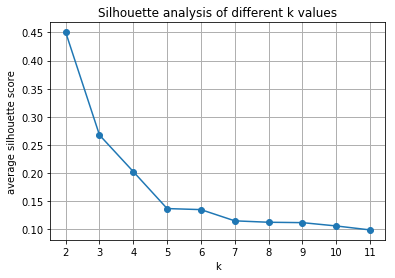

In [15]:
silhouette_analysis(a)

#### I choose k=6.

In [16]:
model6 = KMeans(n_clusters=6, max_iter=500, n_init=10)
t0 = time.time()
model6.fit(a)
t_batch = time.time() - t0
y_pred6 = model6.predict(a)
print(model6.inertia_)
print(silhouette_score(a, model6.fit_predict(a)))
print(t_batch)

1076634.329248175
0.13534004202903344
1.4004321098327637


#### coloring each record by predicted cluster number.

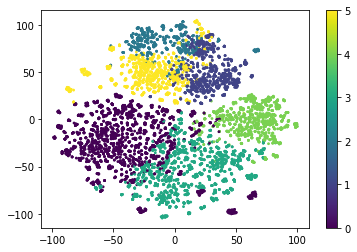

In [21]:
sc = plt.scatter(x[:,0], x[:,1], lw=0, s=8, c=y_pred6)

plt.colorbar(sc)

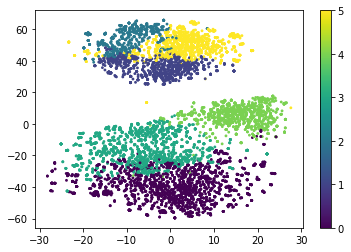

In [20]:
sc = plt.scatter(x_b[:,0], x_b[:,1], lw=0, s=8, c=y_pred6)

plt.colorbar(sc)

## Experiment II (K-means with IG)

#### Implement feature selection by calculating Shannon entropy to get information gain (IG) of each feature.

In [7]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet) 
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]   
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1  
    shannonEnt = 0.0
    for key in labelCounts:  
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2) 
    return shannonEnt
    
def splitDataSet(data,feature,value):
    #return splitted data
    newdata=[]
    for rows in data:
        if rows[feature]==value : 
            reduceFeatVec=rows[:feature]
            reduceFeatVec.extend(rows[feature+1:])
            newdata.append(reduceFeatVec)
    return newdata 

def rankFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1  
    baseEntropy = calcShannonEnt(dataSet)   
    bestInfoGain = 0.0; 
    rankFeature = dict()
    for i in range(numFeatures):   
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:  
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)     
        infoGain = baseEntropy - newEntropy  
        rankFeature[i]=rankFeature.setdefault(i,0)+infoGain
    return rankFeature

#### sort features by their information gain (IG) and choose top 21 informative features.

In [8]:
rank = rankFeatureToSplit(a.tolist())

rank21 = sorted(rank.items(), key=itemgetter(1), reverse=True)[0:21]

feature21 = []
for i in range(21):
    feature21.append(rank21[i][0])
feature21.sort()
print(feature21)

[0, 4, 13, 16, 17, 21, 22, 27, 29, 30, 33, 34, 35, 36, 42, 46, 48, 54, 58, 63, 67]


In [8]:
dictionary_file = open("/v3io/bigdata/intelligence/tic2000/ticdictionary.txt", "r", errors='ignore')

dictionary_lines = dictionary_file.readlines()

print(len(dictionary_lines))

dictionary_file.close()

ids = [int(l.split(' ')[0]) for l in dictionary_lines]

names = [l.split(' ')[1] for l in dictionary_lines]

descriptions = [' '.join(l.split(' ')[2:])[0:-1] for l in dictionary_lines]

dictionary_df = pd.DataFrame({'id': ids, 'name': names, 'description': descriptions})

print(dictionary_df.shape)

dictionary_df.head()

86
(86, 3)


id      name                description
0   1   MOSTYPE    Customer Subtype see L0
1   2  MAANTHUI     Number of houses 1  10
2   3   MGEMOMV    Avg size household 1  6
3   4  MGEMLEEF             Avg age see L1
4   5  MOSHOOFD  Customer main type see L2

In [9]:
rank21_df = pd.DataFrame(rank21)

rank21_df.columns = ['feature id', 'information gain']

rank21_df['feature id'] += 1

rank21_df2 = pd.merge(rank21_df, dictionary_df, left_on = 'feature id', right_on = 'id')

del rank21_df2['id']

print(rank21_df2.to_string(index=False))

feature id  information gain      name                                      description
        64          0.104907  PBYSTAND  Contribution social security insurance policies
        68          0.008418  APERSAUT                           Number of car policies
        47          0.006326  PPERSAUT                        Contribution car policies
         1          0.005568   MOSTYPE                          Customer Subtype see L0
        59          0.004368    PBRAND                       Contribution fire policies
        43          0.003093  MKOOPKLA                           Purchasing power class
         5          0.003089  MOSHOOFD                        Customer main type see L2
        14          0.002784  MFGEKIND                       Household without children
        18          0.002312  MOPLLAAG                            Lower level education
        34          0.002274     MAUT0                                           No car
        49          0.002180   P

#### visualize feature "customer main type" with historgram

Text(0.5, 1.0, 'Customer main type')

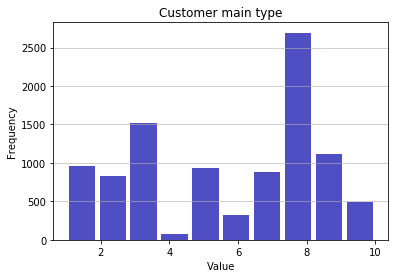

In [34]:
n, bins, patches = plt.hist(x=a[:,4], bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Customer main type')

#### visualize feature "customer subtype" with histogram

Text(0.5, 1.0, 'Customer Subtype')

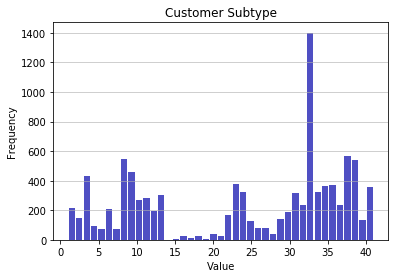

In [35]:
n, bins, patches = plt.hist(x=a[:,0], bins=41, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Customer Subtype')

#### visualize feature "contribution social security insurance policies" with histogram

In [36]:
Counter(a[:, 63])

Counter({0.0: 9687, 4.0: 68, 3.0: 34, 2.0: 31, 5.0: 2})

Text(0.5, 1.0, 'Contribution social security insurance policies')

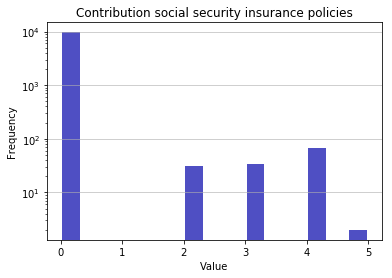

In [37]:
n, bins, patches = plt.hist(x=a[:,63], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85, log=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Contribution social security insurance policies')

In [38]:
Counter(a[:, 67])

Counter({1.0: 4580,
         0.0: 4825,
         2.0: 384,
         7.0: 1,
         3.0: 21,
         6.0: 1,
         4.0: 8,
         12.0: 1,
         5.0: 1})

Text(0.5, 1.0, 'Number of car policies')

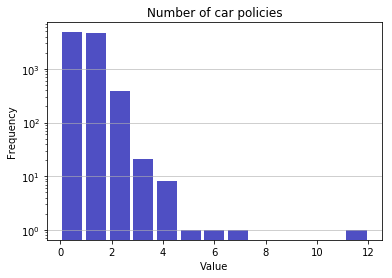

In [39]:
n, bins, patches = plt.hist(x=a[:,67], bins=13, color='#0504aa',
                            alpha=0.7, rwidth=0.85, log=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Number of car policies')

In [40]:
Counter(a[:, 46])

Counter({6.0: 3910, 0.0: 4825, 5.0: 1013, 7.0: 64, 8.0: 5, 4.0: 4, 9.0: 1})

Text(0.5, 1.0, 'Contribution car policies')

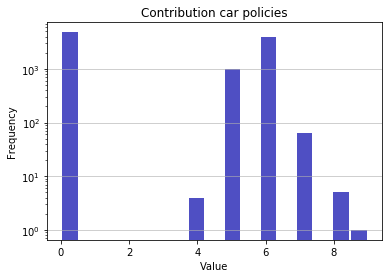

In [41]:
n, bins, patches = plt.hist(x=a[:,46], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85, log=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Contribution car policies')

In [42]:
Counter(a[:, 58])

Counter({5.0: 263,
         2.0: 901,
         6.0: 252,
         0.0: 4464,
         3.0: 1541,
         4.0: 2142,
         1.0: 245,
         7.0: 12,
         8.0: 2})

Text(0.5, 1.0, 'Contribution fire policies')

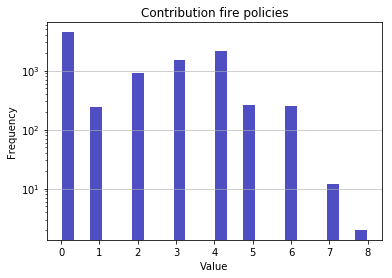

In [43]:
n, bins, patches = plt.hist(x=a[:,58], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85, log=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Contribution fire policies')

In [44]:
Counter(a[:, 42])

Counter({3.0: 2556,
         4.0: 1539,
         5.0: 964,
         7.0: 777,
         2.0: 731,
         6.0: 1587,
         1.0: 938,
         8.0: 730})

Text(0.5, 1.0, 'Purchasing power class')

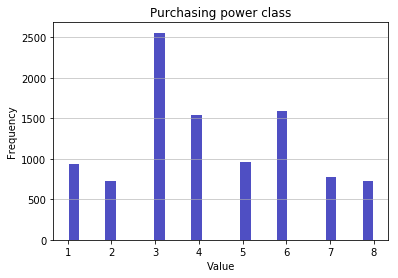

In [45]:
n, bins, patches = plt.hist(x=a[:,42], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Purchasing power class')

#### select the subset including only top 21 informative features.

In [10]:
a21 = a[:, feature21]

#### visualize the subset including only top 21 informative features using t-SNE with default options

In [9]:
x21 = TSNE(random_state=20190509).fit_transform(a21)

#### Coloring each record by customer subtype (L0)

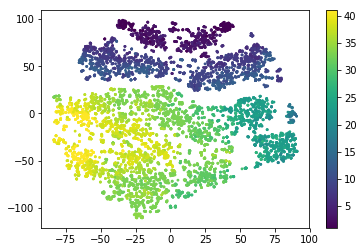

In [46]:
sc = plt.scatter(x21[:,0], x21[:,1], lw=0, s=8, c=list(a21[:,0]))

plt.colorbar(sc)

#### visualize the subset including only top 21 informative features using t-SNE with tuned options

In [11]:
x21_b = TSNE(random_state=20190509, perplexity=300, early_exaggeration=20,learning_rate=100).fit_transform(a21)

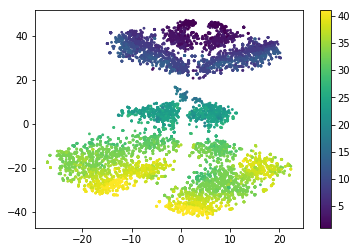

In [12]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=list(a21[:,0]))

plt.colorbar(sc)

#### Coloring each record by customer main type (L2)

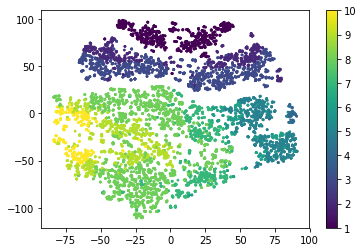

In [49]:
sc = plt.scatter(x21[:,0], x21[:,1], lw=0, s=8, c=list(a[:,4]))

plt.colorbar(sc)

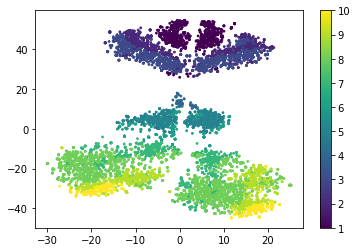

In [50]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=list(a[:,4]))

plt.colorbar(sc)

#### each record colored by Contribution social security insurance policies

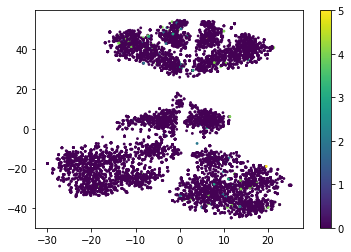

In [11]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=list(a[:,63]))

plt.colorbar(sc)

#### each record colored by Number of car policies

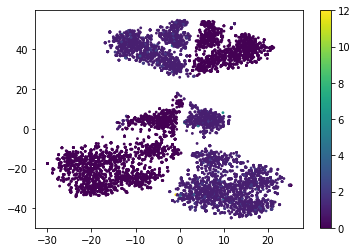

In [12]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=list(a[:,67]))

plt.colorbar(sc)

#### each record colored by Contribution car policies

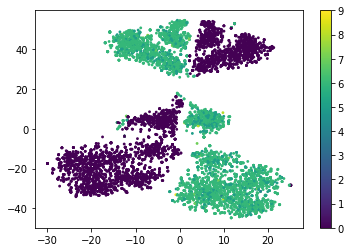

In [13]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=list(a[:,46]))

plt.colorbar(sc)

#### each record colored by Contribution fire policies

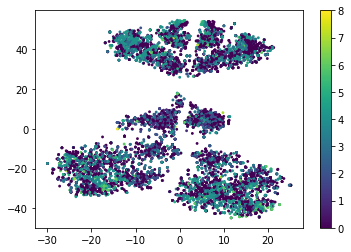

In [14]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=list(a[:,58]))

plt.colorbar(sc)

#### each record colored by Purchasing power class

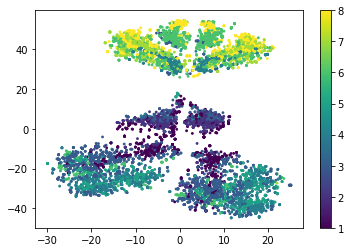

In [15]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=list(a[:,42]))

plt.colorbar(sc)

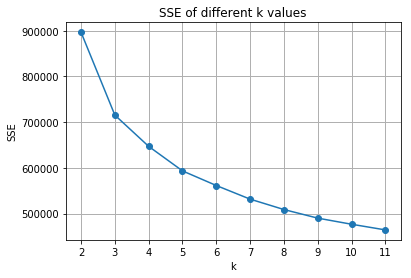

In [51]:
elbow(a21)

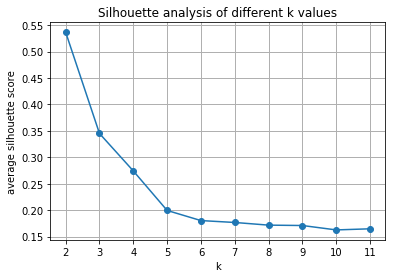

In [52]:
silhouette_analysis(a21)

#### Try k = 4

In [53]:
model21_4 = KMeans(n_clusters=4, max_iter=500, n_init=10)
t0 = time.time()
model21_4.fit(a21)
t_batch = time.time() - t0
y_pred21_4 = model21_4.predict(a21)
print(model21_4.inertia_)
print(silhouette_score(a21, model21_4.fit_predict(a21)))
print(t_batch)

647145.4562149452
0.2746377710654033
0.30748891830444336


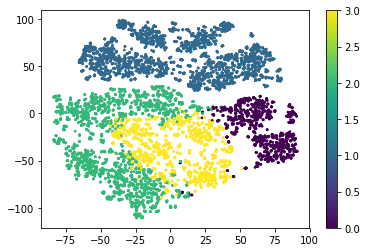

In [59]:
sc = plt.scatter(x21[:,0], x21[:,1], lw=0, s=8, c=y_pred21_4)

plt.colorbar(sc)

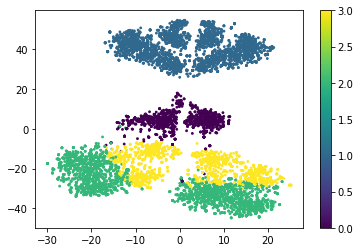

In [60]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=y_pred21_4)

plt.colorbar(sc)

#### Try k = 5

In [56]:
model21_5 = KMeans(n_clusters=5, max_iter=500, n_init=10)
t0 = time.time()
model21_5.fit(a21)
t_batch = time.time() - t0
y_pred21_5 = model21_5.predict(a21)
print(model21_5.inertia_)
print(silhouette_score(a21, model21_5.fit_predict(a21)))
print(t_batch)

593526.2868062885
0.19950486907972032
0.39046406745910645


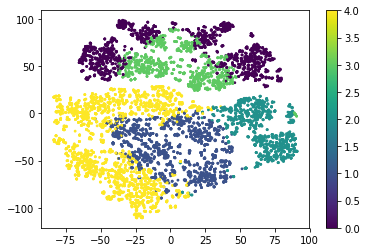

In [61]:
sc = plt.scatter(x21[:,0], x21[:,1], lw=0, s=8, c=y_pred21_5)

plt.colorbar(sc)

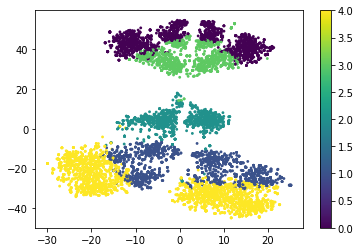

In [62]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=y_pred21_5)

plt.colorbar(sc)

#### Try k = 6

In [63]:
model21_6 = KMeans(n_clusters=6, max_iter=500, n_init=10)
t0 = time.time()
model21_6.fit(a21)
t_batch = time.time() - t0
y_pred21_6 = model21_6.predict(a21)
print(model21_6.inertia_)
print(silhouette_score(a21, model21_6.fit_predict(a21)))
print(t_batch)

561520.6811694271
0.1799167049193387
0.44591617584228516


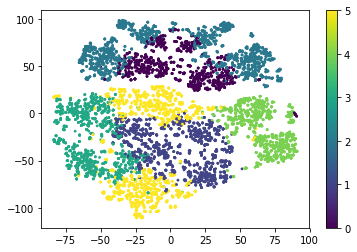

In [64]:
sc = plt.scatter(x21[:,0], x21[:,1], lw=0, s=8, c=y_pred21_6)

plt.colorbar(sc)

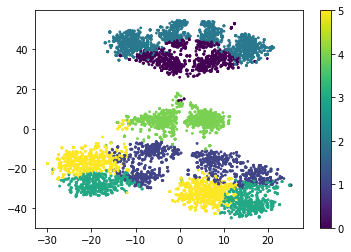

In [65]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=y_pred21_6)

plt.colorbar(sc)

#### Try K = 7

In [66]:
model21_7 = KMeans(n_clusters=7, max_iter=500, n_init=10)
t0 = time.time()
model21_7.fit(a21)
t_batch = time.time() - t0
y_pred21_7 = model21_7.predict(a21)
print(model21_7.inertia_)
print(silhouette_score(a21, model21_7.fit_predict(a21)))
print(t_batch)

531714.5593307355
0.176621282465487
0.4289238452911377


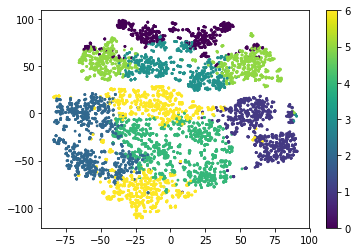

In [67]:
sc = plt.scatter(x21[:,0], x21[:,1], lw=0, s=8, c=y_pred21_7)

plt.colorbar(sc)

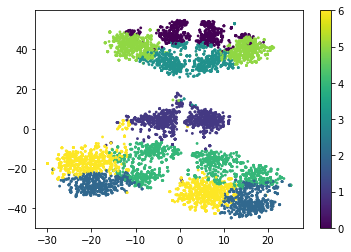

In [68]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=y_pred21_7)

plt.colorbar(sc)

#### Try K = 8

In [69]:
model21_8 = KMeans(n_clusters=8, max_iter=500, n_init=10)
t0 = time.time()
model21_8.fit(a21)
t_batch = time.time() - t0
y_pred21_8 = model21_8.predict(a21)
print(model21_8.inertia_)
print(silhouette_score(a21, model21_8.fit_predict(a21)))
print(t_batch)

508981.58967257483
0.17196595127680586
0.5132155418395996


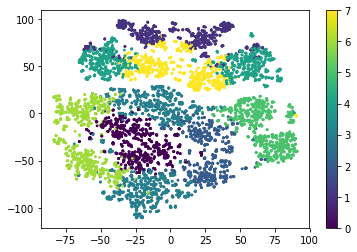

In [70]:
sc = plt.scatter(x21[:,0], x21[:,1], lw=0, s=8, c=y_pred21_8)

plt.colorbar(sc)

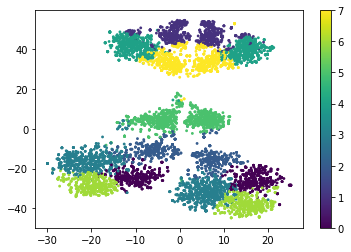

In [71]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=y_pred21_8)

plt.colorbar(sc)

#### I choose k = 5 and here is its centroids table.

In [72]:
# [0, 4, 13, 16, 17, 21, 22, 27, 29, 30, 33, 34, 35, 36, 42, 46, 48, 54, 58, 63, 67]

features = [str(i+1) + '-' + names[i] for i in feature21]

clus5 = model21_5.cluster_centers_
clustroids5 = pd.DataFrame(clus5.T,index=features,columns='Cluster_0 Cluster_1 Cluster_2 Cluster_3 Cluster_4'.split())
clustroids5.round(3)

Cluster_0  Cluster_1  Cluster_2  Cluster_3  Cluster_4
1-MOSTYPE       35.736     23.489     34.225      8.478      6.994
5-MOSHOOFD       8.423      5.211      7.951      2.428      2.012
14-MFGEKIND      3.318      3.277      3.003      3.149      3.379
17-MOPLMIDD      3.165      3.518      2.272      4.081      3.939
18-MOPLLAAG      5.200      4.494      6.455      3.517      2.524
22-MBERMIDD      2.494      3.063      2.415      3.665      3.311
23-MBERARBG      2.532      2.256      3.010      1.811      1.210
28-MSKC          3.988      3.781      5.104      3.458      2.146
30-MHHUUR        2.234      6.926      7.193      6.217      1.068
31-MHKOOP        6.769      2.085      1.816      2.792      7.940
34-MAUT0         1.628      3.256      2.552      1.966      0.994
35-MZFONDS       6.301      6.981      7.514      6.053      4.557
36-MZPART        2.705      2.019      1.491      2.948      4.452
37-MINKM30       2.004      4.006      3.956      2.638      1.082
43-MKOOPKLA      3.783      2.095      3.076      5.550      6.815
47-PPERSAUT      2.982      2.658      2.973      3.020      3.059
49-PMOTSCO       0.184      0.126      0.160      0.165      0.195
55-PLEVEN        0.180      0.113      0.167      0.272      0.288
59-PBRAND        2.147      1.315      1.568      1.625      2.172
64-PBYSTAND      0.040      0.023      0.021      0.052      0.089
68-APERSAUT      0.573      0.491      0.551      0.567      0.577

## Experiment III (K-means with IG and one hot encoding)

#### add one hot encoding for categorial variables (customer main type, customer subtype);

In [11]:
from sklearn.preprocessing import OneHotEncoder

enc_0 = OneHotEncoder(sparse=False, categories='auto')

one_hot_0 = enc_0.fit_transform(df[[0]])

print(enc_0.categories_)

enc_4 = OneHotEncoder(sparse=False, categories='auto')

one_hot_4 = enc_4.fit_transform(df[[4]])

print(enc_4.categories_)

[array(['1', '10', '11', '12', '13', '15', '16', '17', '18', '19', '2',
       '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4',
       '40', '41', '5', '6', '7', '8', '9'], dtype=object)]
[array(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)]


In [12]:
a21_onehot = a21[:,2:]

a21_onehot = np.c_[one_hot_0, a21_onehot]
a21_onehot = np.c_[one_hot_4, a21_onehot]

a21_onehot.shape

(9822, 69)

In [75]:
x21_onehot = TSNE(random_state=20190509).fit_transform(a21_onehot)

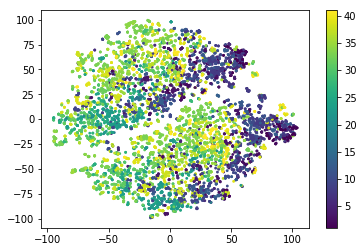

In [76]:
sc = plt.scatter(x21_onehot[:,0], x21_onehot[:,1], lw=0, s=8, c=list(a[:,0]))

plt.colorbar(sc)

In [77]:
x21_onehot_b = TSNE(random_state=20190509, perplexity=300, early_exaggeration=20).fit_transform(a21_onehot)

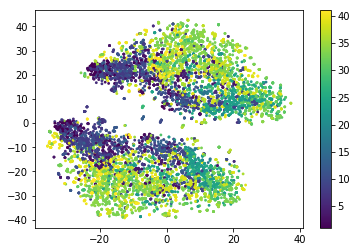

In [78]:
sc = plt.scatter(x21_onehot_b[:,0], x21_onehot_b[:,1], lw=0, s=8, c=list(a[:,0]))

plt.colorbar(sc)

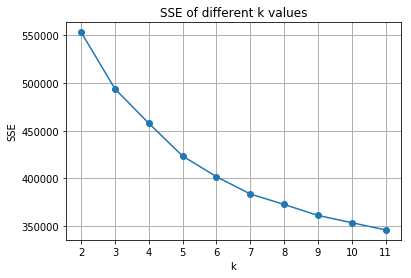

In [79]:
elbow(a21_onehot)

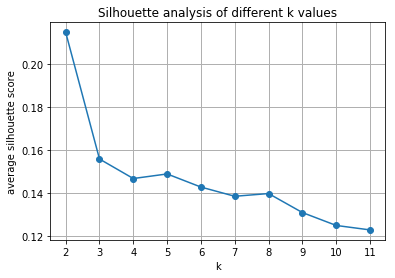

In [80]:
silhouette_analysis(a21_onehot)

#### Try K = 5

In [81]:
model21_onehot_5 = KMeans(n_clusters=5, max_iter=500, n_init=10)
t0 = time.time()
model21_onehot_5.fit(a21_onehot)
t_batch = time.time() - t0
y_pred21_onehot_5 = model21_onehot_5.predict(a21_onehot)
print(model21_onehot_5.inertia_)
print(silhouette_score(a21_onehot, model21_onehot_5.fit_predict(a21_onehot)))
print(t_batch)

423455.0510550793
0.14904580656914554
1.064237356185913


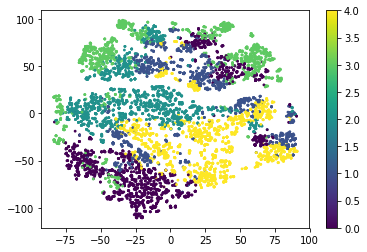

In [85]:
sc = plt.scatter(x21[:,0], x21[:,1], lw=0, s=8, c=y_pred21_onehot_5)

plt.colorbar(sc)

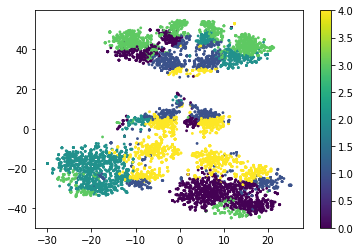

In [86]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=y_pred21_onehot_5)

plt.colorbar(sc)

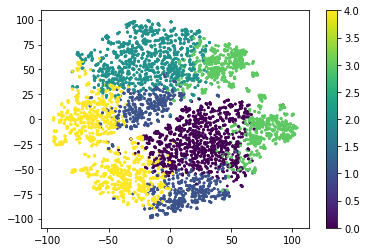

In [82]:
sc = plt.scatter(x21_onehot[:,0], x21_onehot[:,1], lw=0, s=8, c=y_pred21_onehot_5)

plt.colorbar(sc)

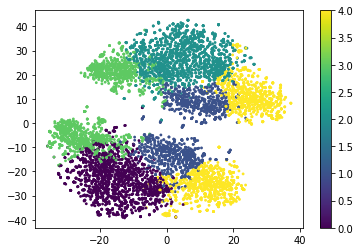

In [83]:
sc = plt.scatter(x21_onehot_b[:,0], x21_onehot_b[:,1], lw=0, s=8, c=y_pred21_onehot_5)

plt.colorbar(sc)

#### Try K = 8

In [84]:
model21_onehot_8 = KMeans(n_clusters=8, max_iter=500, n_init=10)
t0 = time.time()
model21_onehot_8.fit(a21_onehot)
t_batch = time.time() - t0
y_pred21_onehot_8 = model21_onehot_8.predict(a21_onehot)
print(model21_onehot_8.inertia_)
print(silhouette_score(a21_onehot, model21_onehot_8.fit_predict(a21_onehot)))
print(t_batch)

371410.0585423865
0.13988667971155155
1.4281046390533447


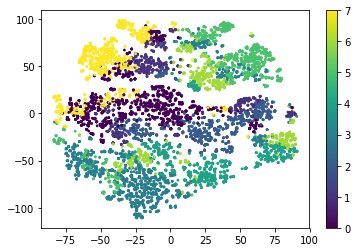

In [87]:
sc = plt.scatter(x21[:,0], x21[:,1], lw=0, s=8, c=y_pred21_onehot_8)

plt.colorbar(sc)

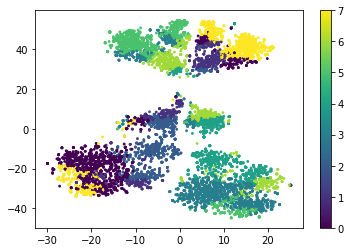

In [88]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=y_pred21_onehot_8)

plt.colorbar(sc)

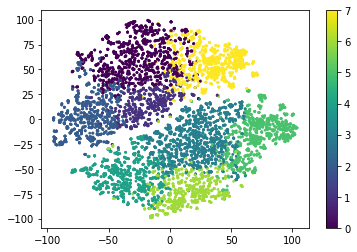

In [89]:
sc = plt.scatter(x21_onehot[:,0], x21_onehot[:,1], lw=0, s=8, c=y_pred21_onehot_8)

plt.colorbar(sc)

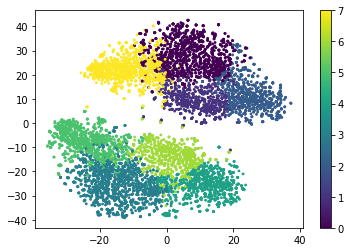

In [90]:
sc = plt.scatter(x21_onehot_b[:,0], x21_onehot_b[:,1], lw=0, s=8, c=y_pred21_onehot_8)

plt.colorbar(sc)

## Experiment IV (K-means with IG, one-hot encoding and data normalization)

#### use the default data normalization provided by sklearn

In [13]:
from sklearn.preprocessing import normalize

a21_onehot_norm = normalize(a21_onehot)

print(a21_onehot_norm[0])

print(a21_onehot_norm[:,0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.05538488 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.05538488
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.11076976 0.11076976 0.38769414 0.11076976
 0.27692439 0.33230927 0.05538488 0.44307902 0.05538488 0.44307902
 0.05538488 0.         0.16615463 0.33230927 0.         0.
 0.27692439 0.         0.05538488]
[0. 0. 0. ... 0. 0. 0.]


In [92]:
x21_onehot_norm = TSNE(random_state=20190509).fit_transform(a21_onehot_norm)

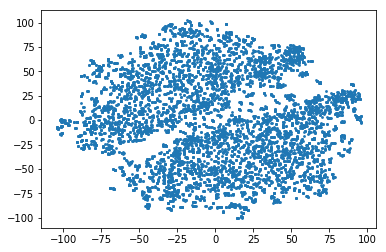

In [94]:
plt.scatter(x21_onehot_norm[:,0], x21_onehot_norm[:,1], lw=0, s=8)

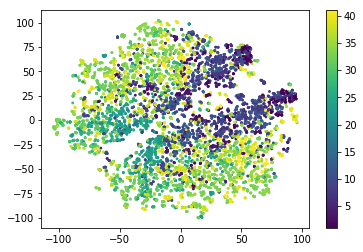

In [95]:
sc = plt.scatter(x21_onehot_norm[:,0], x21_onehot_norm[:,1], lw=0, s=8, c=list(a[:,0]))

plt.colorbar(sc)

In [96]:
x21_onehot_norm_b = TSNE(random_state=20190509, perplexity=300, early_exaggeration=20).fit_transform(a21_onehot_norm)

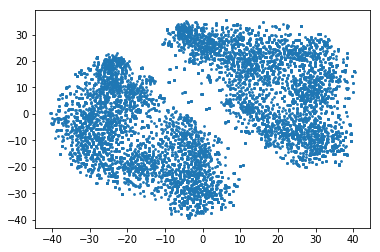

In [97]:
plt.scatter(x21_onehot_norm_b[:,0], x21_onehot_norm_b[:,1], lw=0, s=8)

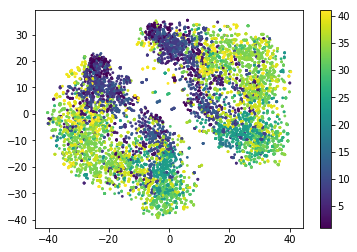

In [98]:
sc = plt.scatter(x21_onehot_norm_b[:,0], x21_onehot_norm_b[:,1], lw=0, s=8, c=list(a[:,0]))

plt.colorbar(sc)

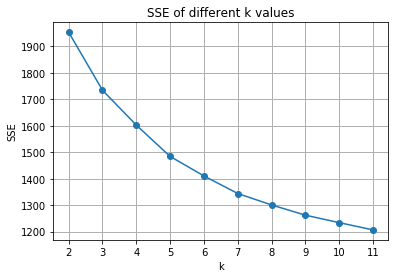

In [99]:
elbow(a21_onehot_norm)

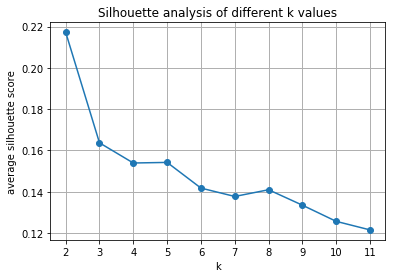

In [100]:
silhouette_analysis(a21_onehot_norm)

#### Try K = 5

In [101]:
model21_onehot_norm_5 = KMeans(n_clusters=5, max_iter=500, n_init=10)
t0 = time.time()
model21_onehot_norm_5.fit(a21_onehot_norm)
t_batch = time.time() - t0
y_pred21_onehot_norm_5 = model21_onehot_norm_5.predict(a21_onehot_norm)
print(model21_onehot_norm_5.inertia_)
print(silhouette_score(a21_onehot_norm, model21_onehot_norm_5.fit_predict(a21_onehot_norm)))
print(t_batch)

1484.201777096959
0.15410590528648324
0.7858855724334717


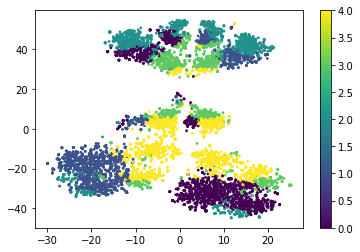

In [110]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=y_pred21_onehot_norm_5)

plt.colorbar(sc)

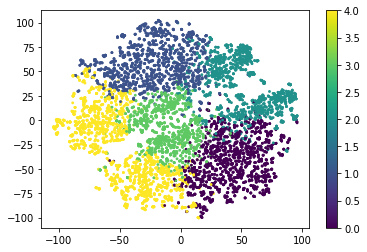

In [102]:
sc = plt.scatter(x21_onehot_norm[:,0], x21_onehot_norm[:,1], lw=0, s=8, c=y_pred21_onehot_norm_5)

plt.colorbar(sc)

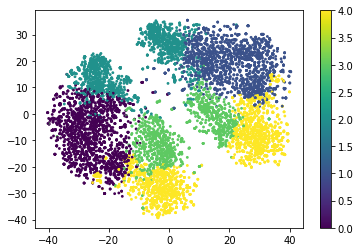

In [103]:
sc = plt.scatter(x21_onehot_norm_b[:,0], x21_onehot_norm_b[:,1], lw=0, s=8, c=y_pred21_onehot_norm_5)

plt.colorbar(sc)

#### Try K = 8

In [104]:
model21_onehot_norm_8 = KMeans(n_clusters=8, max_iter=500, n_init=10)
t0 = time.time()
model21_onehot_norm_8.fit(a21_onehot_norm)
t_batch = time.time() - t0
y_pred21_onehot_norm_8 = model21_onehot_norm_8.predict(a21_onehot_norm)
print(model21_onehot_norm_8.inertia_)
print(silhouette_score(a21_onehot_norm, model21_onehot_norm_8.fit_predict(a21_onehot_norm)))
print(t_batch)

1300.833714147227
0.14116237686488659
1.5885639190673828


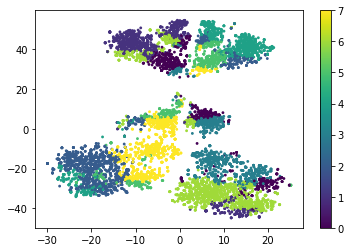

In [108]:
sc = plt.scatter(x21_b[:,0], x21_b[:,1], lw=0, s=8, c=y_pred21_onehot_norm_8)

plt.colorbar(sc)

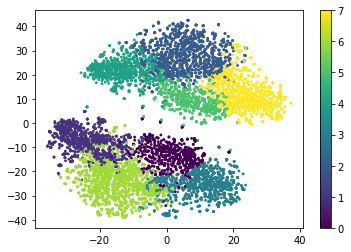

In [109]:
sc = plt.scatter(x21_onehot_b[:,0], x21_onehot_b[:,1], lw=0, s=8, c=y_pred21_onehot_norm_8)

plt.colorbar(sc)

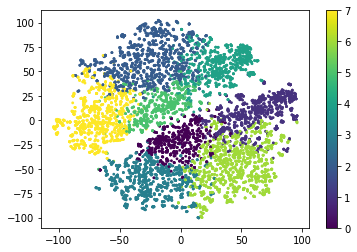

In [105]:
sc = plt.scatter(x21_onehot_norm[:,0], x21_onehot_norm[:,1], lw=0, s=8, c=y_pred21_onehot_norm_8)

plt.colorbar(sc)

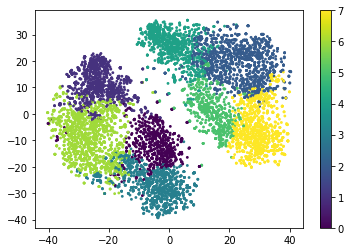

In [106]:
sc = plt.scatter(x21_onehot_norm_b[:,0], x21_onehot_norm_b[:,1], lw=0, s=8, c=y_pred21_onehot_norm_8)

plt.colorbar(sc)

## Experiment V (K-means with SOM) 

In [15]:
from minisom import MiniSom 

som = MiniSom(26,15, a21_onehot_norm.shape[1], sigma=10, learning_rate=0.2)

som.random_weights_init(a21_onehot_norm)

som.train_random(a21_onehot_norm,2000)

In [17]:
new_data=[]
for i,row in enumerate(a21_onehot_norm):
    print((str(i+1))+' of 9822',end='\r')
    coor=som.winner(row)
    new_data.append([coor[0],coor[1]])

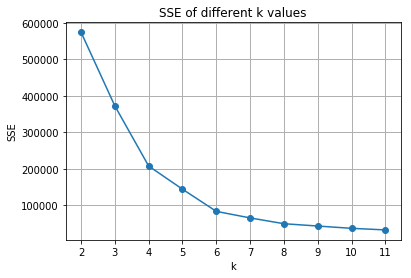

In [18]:
elbow(new_data)

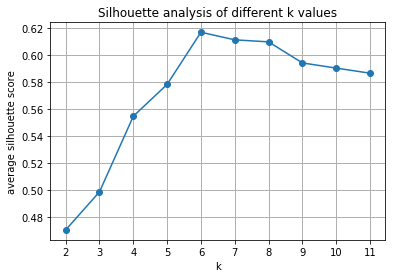

In [19]:
silhouette_analysis(new_data)

In [24]:
model_som = KMeans(n_clusters=6, max_iter=500, n_init=100)
t0 = time.time()
model_som = model_som.fit(new_data)
t_batch = time.time() - t0
y_predsom=model_som.predict(new_data)
print(model_som.inertia_)
print(silhouette_score(new_data, model_som.fit_predict(new_data)))
print(t_batch)

83121.35975324245
0.6169954733141696
1.2811875343322754


In [25]:
features=["som1","som2"]
clus1=model_som.cluster_centers_
clustroids1 = pd.DataFrame(clus1.T,index=features,columns='Cluster_0 Cluster_1 Cluster_2 Cluster_3 Cluster_4 Cluster_5 '.split())
clustroids1.round(3)

Cluster_0  Cluster_1  Cluster_2  Cluster_3  Cluster_4  Cluster_5
som1     23.520      1.943      1.372     12.936     23.749     11.821
som2      1.235     12.777      0.453     13.230     12.915      0.427

In [26]:
def re_org_data(new_data):
    re_new_data=new_data
    re_new_data=re_new_data.astype(np.float64)
    for row in re_new_data:
        row[0]=float(row[0])+np.random.normal(loc=0.0, scale=0.5,size=1)
        row[1]=float(row[1])+np.random.normal(loc=0.0, scale=0.5,size=1)
    return re_new_data

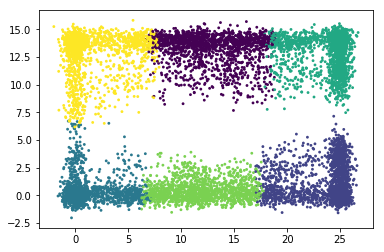

In [27]:
new_data=np.array(new_data)
re_new_data=re_org_data(new_data)
plt.scatter(re_new_data[:,0],re_new_data[:,1],lw=0, s=8, c=y_predsom)

## Clustering analysis

#### cluster 0 (the left one in the first row)：Customer subtype 1 ~ 5, Number of car policies >=1, Contribution car policies >=1
#### cluster 1(the right one in the first row)：Customer subtype 1 ~ 5, Number of car policies 0, Contribution car policies 0
#### cluster 2(the left one in the second row)：Customer subtype 5 ~ 15, Number of car policies >=1, Contribution car policies >=1
#### cluster 3(the right one in the second row)：Customer subtype 5 ~ 15, Number of car policies 0, Contribution car policies 0
#### cluster 4(the left one in the third row)：Customer subtype 15 ~ 28，Number of car policies 0, Contribution car policies 0
#### cluster 5(the right one in the third row)：Customer subtype 15 ~ 28，Number of car policies >=1, Contribution car policies >=1
#### cluster 6(the left one in the forth row)：Customer subtype 29 ~ 41，Number of car policies 0, Contribution car policies 0
#### cluster 7(the right one in the forth row)：Customer subtype 29 ~ 41，Number of car policies >=1, Contribution car policies >=1

In [133]:
feature3=[0,46,67]
a_3=a[:, feature3]
x_clus=np.c_[x21_b,a_3]
clus0=x_clus[np.where( (x_clus[:,2]>0) & (x_clus[:,2]<6) & (x_clus[:,3] > 0) & (x_clus[:,4] > 0))]
clus1=x_clus[np.where( (x_clus[:,2]>0) & (x_clus[:,2]<6) & (x_clus[:,3] == 0) & (x_clus[:,4] == 0))]
clus2=x_clus[np.where( (x_clus[:,2]>5) & (x_clus[:,2]<15) & (x_clus[:,3] > 0) & (x_clus[:,4] > 0))]
clus3=x_clus[np.where( (x_clus[:,2]>5) & (x_clus[:,2]<15) & (x_clus[:,3] == 0) & (x_clus[:,4] == 0))]
clus4=x_clus[np.where( (x_clus[:,2]>14) & (x_clus[:,2]<29) & (x_clus[:,3] == 0) & (x_clus[:,4] == 0))]
clus5=x_clus[np.where( (x_clus[:,2]>14) & (x_clus[:,2]<29) & (x_clus[:,3] > 0) & (x_clus[:,4] > 0))]
clus6=x_clus[np.where( (x_clus[:,2]>28) & (x_clus[:,2]<42) & (x_clus[:,3] == 0) & (x_clus[:,4] == 0))]
clus7=x_clus[np.where( (x_clus[:,2]>28) & (x_clus[:,2]<42) & (x_clus[:,3] > 0) & (x_clus[:,4] > 0))]

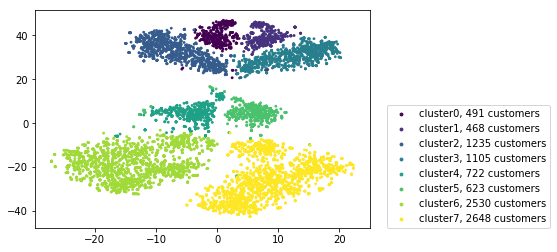

In [137]:
clusters=[clus0,clus1,clus2,clus3,clus4,clus5,clus6,clus7]
for i in range(8):
    clus=clusters[i]
    num=len(clus)
    colors=i*np.ones(num)
    sc=plt.scatter(clus[:,0], clus[:,1], lw=0, s=8, c=colors,vmax=7,vmin=0)
    plt.scatter([], [],s=8,c=sc.to_rgba(colors[0]),label="cluster" + str(i) +", "+ str(num)+" customers") 
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.show()
